# **41079 Computer Science Studio 2**
## *Notebook 2: Model Training & Evaluation*

---
## **1. Introduction & Set Up**

#### **1.1. Import Necessary Libaries/Packages**

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

#### **1.2. Load Model and Tokeniser**

In [3]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", normalization=True)
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-large", num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **1.3. Load Preprocessed Data**

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#### **1.4. Set Device to GPU (if Available)**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (f"Device: {device}")

Device: cuda


---
## **2. Token Length Analysis**

#### **2.1. Analyse Token Lengths to Inform Truncation Strategy**

In [6]:
# Calculate raw token lengths
lengths = [len(tokenizer(text, truncation=False, padding=False)['input_ids']) for text in train_df['text']]

# Display key statistics
print(f"Mean Token Length: {np.mean(lengths):.2f}")
print(f"Median Token Length: {np.median(lengths):.2f}")
print(f"Max Token Length: {np.max(lengths)}")
print(f"90th Percentile Token Length: {np.percentile(lengths, 90):.2f}")
print(f"95th Percentile Token Length: {np.percentile(lengths, 95):.2f}")

# Display statistics of samples that are longer than 64 tokens
long_samples = [l for l in lengths if l > 64]
num_long_samples = len(long_samples)
percent_long = (num_long_samples / len(lengths)) * 100

print(f"\nNumber of Samples Longer Than 64 Tokens: {num_long_samples}")
print(f"Percentage of Samples Longer Than 64 Tokens: {percent_long:.2f}%")

Mean Token Length: 28.56
Median Token Length: 29.00
Max Token Length: 143
90th Percentile Token Length: 38.00
95th Percentile Token Length: 41.00

Number of Samples Longer Than 64 Tokens: 68
Percentage of Samples Longer Than 64 Tokens: 0.14%


#### **2.2. Visualise Token Length Distribution with Cutoff**

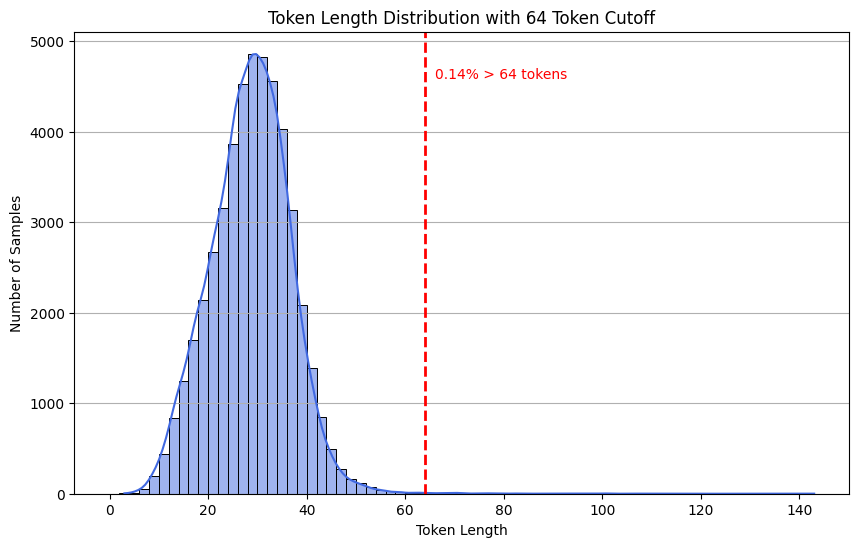

In [7]:
lengths_array = np.array(lengths)
left_percent = (lengths_array <= 64).sum() / len(lengths_array) * 100
right_percent = 100 - left_percent

plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=range(0, 80, 2), color='royalblue', edgecolor='black', kde=True, stat="count")
plt.axvline(x=64, color='red', linestyle='--', linewidth=2)
plt.text(66, plt.gca().get_ylim()[1]*0.9, f'{right_percent:.2f}% > 64 tokens', color='red', ha='left')
plt.title('Token Length Distribution with 64 Token Cutoff')
plt.xlabel('Token Length')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.show()

---
## **3. Dataset Preparation**

#### **3.1. Compute Class Weights for Imbalanced Classes**

In [8]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

#### **3.2. Define Custom Dataset Class & Apply to Splits**

In [9]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=64):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = SentimentDataset(train_df, tokenizer, max_length=64)
test_dataset = SentimentDataset(test_df, tokenizer, max_length=64)

#### **3.3. Define Custom Trainer with Weighted Loss**

In [10]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

---
## **4. Training Configuration & Execution**

#### **4.1. Define Training Arguments**

In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.15,
    lr_scheduler_type="cosine",
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    report_to='none',
    fp16=True
)

#### **4.2. Define Custom Threshold Function & Metric Computation**

In [12]:
def apply_thresholds(logits, thresholds):
    probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    predictions = []
    for probability in probabilities:
        if probability[1] > thresholds[1]:
            predictions.append(1)
        elif probability[2] > thresholds[2]:
            predictions.append(2)
        else:
            predictions.append(0)
    return np.array(predictions)

In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    thresholds = {0: 0.0, 1: 0.4, 2: 0.3}
    predictions = apply_thresholds(logits, thresholds)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

#### **4.3. Initialise Trainer and Begin Training**

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Epoch,Training Loss,Validation Loss


: 

---
## **5. Evaluation & Visualisation**

#### **5.1. Generate Confusion Matrix**

In [ ]:
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for item in test_dataset:
        input_ids = item['input_ids'].unsqueeze(0).to(model.device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(model.device)
        label = item['labels'].item()
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(output.logits, dim=1).item()
        predictions.append(pred)
        true_labels.append(label)

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

---
## **6. Save Model & Tokenizer**

In [40]:
model.save_pretrained('./sentiment_model')
tokenizer.save_pretrained('./sentiment_model')

('./sentiment_model\\tokenizer_config.json',
 './sentiment_model\\special_tokens_map.json',
 './sentiment_model\\vocab.json',
 './sentiment_model\\merges.txt',
 './sentiment_model\\added_tokens.json',
 './sentiment_model\\tokenizer.json')

---
## **7. Grid Search to Find Optimal Class Thresholds**

In [ ]:
def grid_search_thresholds(logits, labels, threshold_values=[0.3, 0.4, 0.5, 0.6, 0.7]):
    best_f1 = 0
    best_thresholds = None

    for t1, t2 in product(threshold_values, repeat=2):
        thresholds = {0: 0.0, 1: t1, 2: t2}
        preds = apply_thresholds(logits, thresholds)
        acc = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
        if f1 > best_f1:
            best_f1 = f1
            best_thresholds = thresholds
            best_metrics = {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

    print(f"Best thresholds found: {best_thresholds}")
    print(f"Metrics: {best_metrics}")
    return best_thresholds

In [ ]:
# Run threshold search on model predictions
logits, labels = trainer.predict(test_dataset).predictions, test_dataset.labels
best_thresholds = grid_search_thresholds(logits, labels)

---
## **X. Delete Me Later!**

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.562000,0.626515,0.722733,0.734450,0.722733,0.718259
2,0.479600,0.607917,0.745699,0.746341,0.745699,0.745079
3,0.355700,0.736935,0.733506,0.740314,0.733506,0.730519
4,0.255700,0.915256,0.738600,0.742000,0.738600,0.737387


TrainOutput(global_step=11976, training_loss=0.44978827592445836, metrics={'train_runtime': 4097.244, 'train_samples_per_second': 70.139, 'train_steps_per_second': 4.384, 'total_flos': 4.463593539288269e+16, 'train_loss': 0.44978827592445836, 'epoch': 4.0})

In [ ]:
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 0.6079167723655701, 'eval_model_preparation_time': 0.0022, 'eval_accuracy': 0.749791214297645, 'eval_precision': 0.7500807125899643, 'eval_recall': 0.749791214297645, 'eval_f1': 0.7498445362781099, 'eval_runtime': 103.6903, 'eval_samples_per_second': 115.479, 'eval_steps_per_second': 7.223}


In [ ]:
# 64 tokens, batchsz=32
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.572400,0.578630,0.728495,0.733518,0.728495,0.726788
2,0.526400,0.565611,0.741440,0.746601,0.741440,0.741712
3,0.418600,0.633844,0.745448,0.748805,0.745448,0.743762
4,0.257800,0.759758,0.746534,0.747368,0.746534,0.746233


TrainOutput(global_step=5988, training_loss=0.4866981614647345, metrics={'train_runtime': 2392.5083, 'train_samples_per_second': 120.115, 'train_steps_per_second': 3.754, 'total_flos': 2.2317967696441344e+16, 'train_loss': 0.4866981614647345, 'epoch': 4.0})

In [ ]:
# 64 tokens, batchsz=16
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.574100,0.607162,0.728245,0.733031,0.728245,0.726266
2,0.492100,0.604736,0.750459,0.751942,0.750459,0.750837
3,0.373000,0.691605,0.737014,0.741695,0.737014,0.734660
4,0.265100,0.863169,0.744780,0.745219,0.744780,0.744452


TrainOutput(global_step=11976, training_loss=0.47919358598763895, metrics={'train_runtime': 3393.808, 'train_samples_per_second': 84.677, 'train_steps_per_second': 5.293, 'total_flos': 2.2317967696441344e+16, 'train_loss': 0.47919358598763895, 'epoch': 4.0})

In [ ]:
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 0.6047362089157104, 'eval_accuracy': 0.7504593285451813, 'eval_precision': 0.7519415809355178, 'eval_recall': 0.7504593285451813, 'eval_f1': 0.750837494548005, 'eval_runtime': 60.7223, 'eval_samples_per_second': 197.193, 'eval_steps_per_second': 12.335, 'epoch': 4.0}


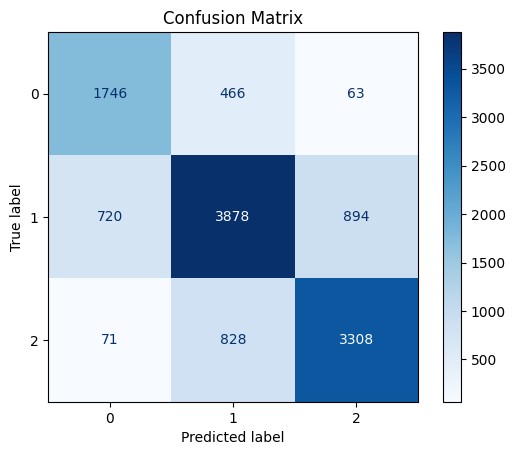

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()